In [1]:
import matplotlib.pyplot as plt
import cv2
import math
import numpy as np
from time import sleep
from tqdm import tqdm


## Requirement 1


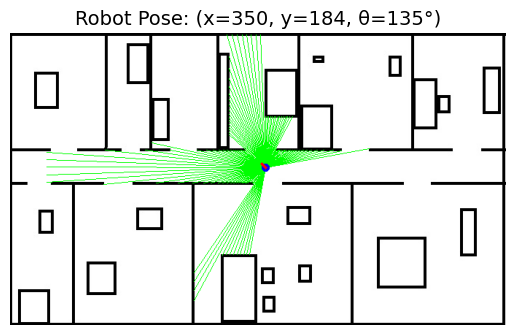

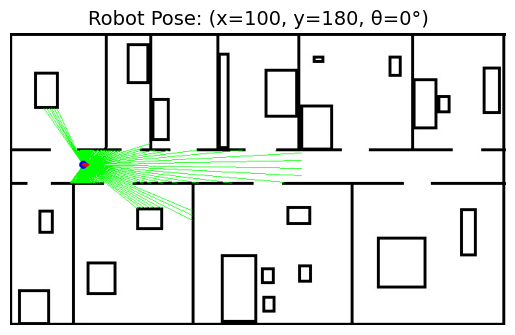

In [25]:
def laser_measurments(map,x,y,theta):
    #convert map to gray scale
    map = cv2.cvtColor(map, cv2.COLOR_BGR2GRAY)
    width=map.shape[1]
    height=map.shape[0]
    max_pixel_range=int(12/0.04)  #12 meters divided by 4 cm per pixel
    measurements={}

    
    for angle in range(-125, 126, 2):
        angle_rad = math.radians(theta + angle)
        cos_angle = math.cos(angle_rad)
        sin_angle = math.sin(angle_rad)
        
        measurements[theta + angle]=(12,(int(x+max_pixel_range*cos_angle),int(y-max_pixel_range*sin_angle)))

        #cast a ray
        for ray in range(max_pixel_range):
            x_pixel = int(x + ray * cos_angle)
            y_pixel = int(y - ray * sin_angle)
            if x_pixel < 0 or x_pixel >= width or y_pixel < 0 or y_pixel >= height: 
                measurements[theta + angle]=(ray*0.04,(x_pixel,y_pixel))
                break
            if map[y_pixel, x_pixel] ==0:
                measurements[theta + angle]=(ray*0.04,(x_pixel,y_pixel))
                break
    return measurements

def draw_laser_measurements(map,measurements,x,y,theta):
    
    #draw the measurements
    for angle in measurements:
        x2 = measurements[angle][1][0]
        y2 = measurements[angle][1][1]
      
        cv2.line(map, (x, y), (x2, y2), (0, 255, 0), 1)
    
    #draw robot orientation
    x2 = int(x + 6 * math.cos(math.radians(theta)))
    y2 = int(y - 6 * math.sin(math.radians(theta)))
   
    #draw the robot's position and orientation 
    cv2.circle(map, (x, y), 3, (255, 0, 0), 3)
    cv2.line(map, (x, y), (x2, y2), (0, 0, 255), 3)
    # Convert BGR image to RGB
    img_rgb = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
    #display the image
    plt.imshow(img_rgb)
    plt.title(f"Robot Pose: (x={x}, y={y}, θ={theta}°)", fontsize=14)
    plt.axis('off')  
    plt.show()


map=cv2.imread("Map.jpg")
x1=350
y1=184
theta1=135
measurements1 = laser_measurments(map, x1,y1,theta1)
draw_laser_measurements(map,measurements1,x1,y1,theta1)

map=cv2.imread("Map.jpg")
x2=100
y2=180
theta2=0


measurements2 = laser_measurments(map, x2,y2,theta2)
draw_laser_measurements(map,measurements2,x2,y2,theta2)


## Requirement 2


In [27]:

def calcaulate_point_probability(likelihood, measurements,pose_bleived):
    x,y,theta=pose_bleived
    width = map.shape[1]
    height = map.shape[0]
    angle=-125
    final_prob=0
    for  measurement in measurements:
            r=measurements[measurement][0] #measurements in meters
            x2 = int(x + r/.04 * math.cos(math.radians(theta+angle)))
            y2 = int(y - r/.04 * math.sin(math.radians(theta+angle)))
            angle+=2
            if x2 < 0 or x2 >=width or y2 < 0 or y2 >= height:
                prob=0.0000001   
            else:
                prob=likelihood[y2][x2]
            #use the log of the probability to prevent underflow
            final_prob+=np.log(prob)  #sum the log of the probabilities
   
    return np.exp(final_prob)
         

   

def find_most_likely_pose(map, measurements):
    Blurred_map= cv2.GaussianBlur(map, (5, 5), 0) #apply a gaussian filter to the map to smooth it
    Blurred_map=255-Blurred_map  #invert the map obstcales are now white (have more probability)
    Blurred_map=Blurred_map/255.0 #normalize the map to be between 0 and 1
    Blurred_map+=0.0000001  #small prob to prevent zero probability

  
    width = map.shape[1]
    height = map.shape[0]
    likelihood=np.zeros((int(height/2),int(width/2)))
    max_propability=0
    best_pose=(0,0,0)
    
    for x in tqdm(range(0,width,2)):   
        for y in range(0,height,2):
            max_propability_for_pixel=0
            for theta in range(0, 361, 5): 
                prob=calcaulate_point_probability(Blurred_map, measurements, (x, y, theta))
                max_propability_for_pixel=max(prob,max_propability_for_pixel)
                if prob>max_propability:
                    max_propability=prob
                    best_pose=(x,y,theta)
            
            likelihood[int(y/2)][int(x/2)]=  max_propability_for_pixel   
    
    return best_pose,likelihood

map=cv2.imread("Map.jpg",cv2.IMREAD_GRAYSCALE)
pos1,image1=find_most_likely_pose(map,measurements1)
pos2,image2=find_most_likely_pose(map,measurements2)
print("first position",pos1)
print("second position",pos2)

100%|██████████| 340/340 [28:26<00:00,  5.02s/it]

first position (350, 184, 135)
second position (100, 180, 0)


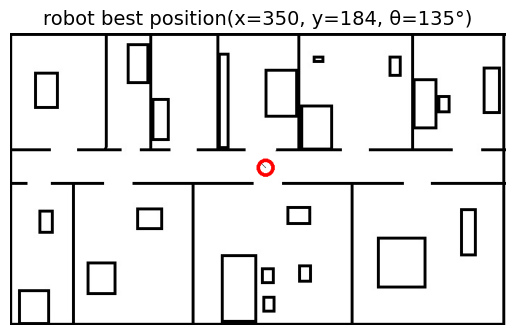

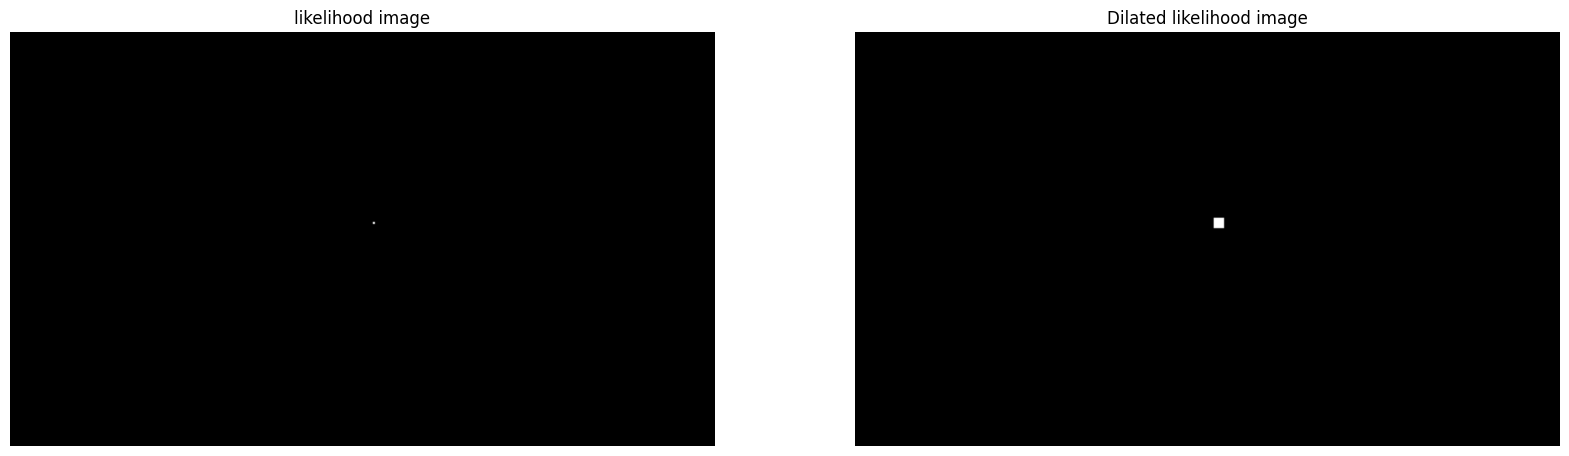

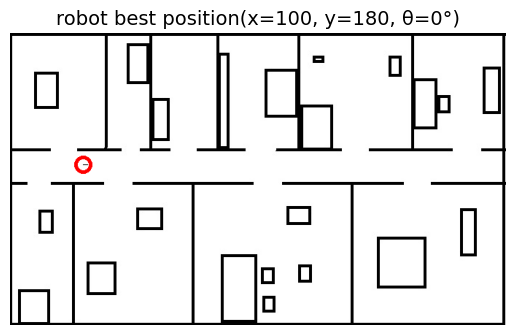

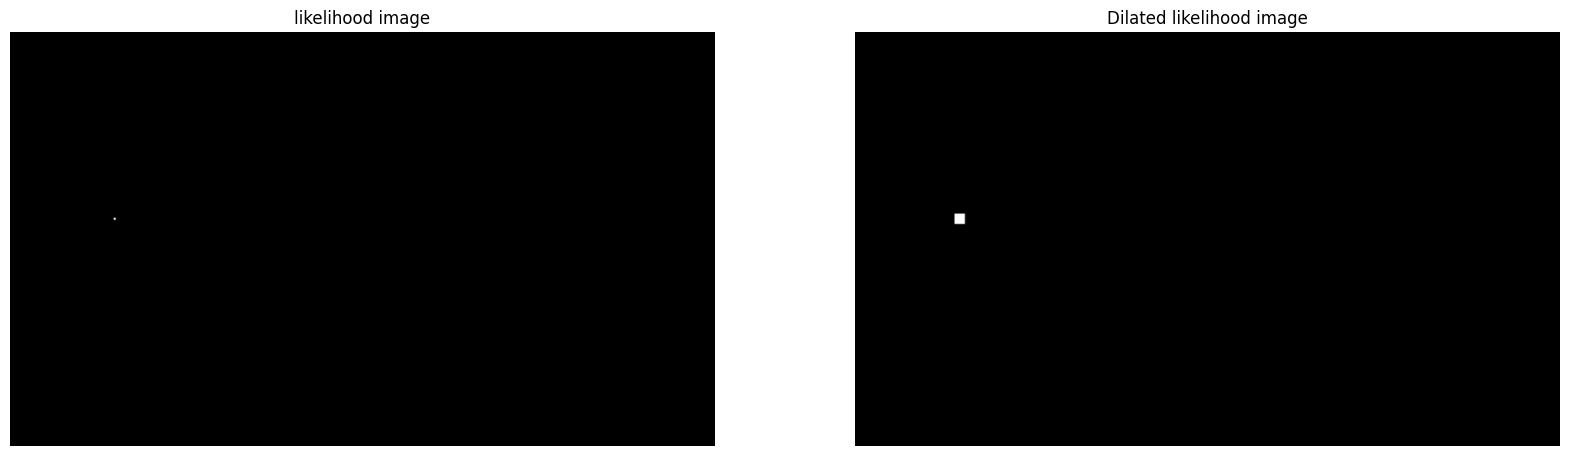

In [41]:
def draw_pose_and_likelihood_image(best_pose,image, map) :
   
    # Convert BGR image to RGB
    map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
    
    (x,y, theta)=best_pose
    
    cv2.circle(map, (x, y), 10, (255, 0, 0), 3)
   
    #draw robot orientation
    x2 = int(x + 6 * math.cos(math.radians(theta)))
    y2 = int(y - 6 * math.sin(math.radians(theta)))
    cv2.line(map, (x, y), (x2, y2), (0, 0, 0), 1)
    
  
    plt.imshow(map)
    plt.axis('off')  
    plt.title(f"robot best position(x={x}, y={y}, θ={theta}°)", fontsize=14)
    plt.show()

   

   #dilate likihood image
    kernel = np.ones((5,5),np.uint8)
    dilated = cv2.dilate(image, kernel, iterations=1)
   
    plt.figure(figsize=(20, 8)) 
    plt.subplot(1, 2, 1) 
    plt.imshow(image, cmap="gray")
    plt.axis('off')  
    plt.title("likelihood image")

    plt.subplot(1, 2, 2)  
   
    plt.imshow(dilated, cmap="gray")
    plt.axis('off')
    plt.title("Dilated likelihood image")
    plt.show()
    
map=cv2.imread("Map.jpg",cv2.IMREAD_GRAYSCALE)
draw_pose_and_likelihood_image(pos1,image1,map)
draw_pose_and_likelihood_image(pos2,image2,map)
